In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split


RuntimeError: CPU dispatcher tracer already initlized

In [3]:
# Dataset 1: Kaggle
DATASET_1_PATH = "DataSets\dataset_1"

# Dataset 2: Kaggle
DATASET_2_PATH = "DataSets\dataset_2"

# Dataset 3: SOCOFing Dataset
SOCOFING_PATH = "datasets/SOCOFing_dataset3"


In [4]:
def load_fingerprint_dataset(base_path, img_size=(128,128)):
    images = []
    labels = []
    
    classes = sorted(os.listdir(base_path))
    
    for label in classes:
        class_path = os.path.join(base_path, label)
        if not os.path.isdir(class_path):
            continue
            
        for img_name in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
            except:
                continue
    
    return np.array(images), np.array(labels)


In [5]:
X1, y1 = load_fingerprint_dataset(DATASET_1_PATH)
X2, y2 = load_fingerprint_dataset(DATASET_2_PATH)

print("Dataset 1:", X1.shape, y1.shape)
print("Dataset 2:", X2.shape, y2.shape)


Loading O-: 100%|██████████| 712/712 [00:12<00:00, 58.60it/s]

Dataset 1: (7920, 128, 128) (7920,)
Dataset 2: (6000, 128, 128) (6000,)


In [6]:
def load_socofing_dataset(base_path, img_size=(128,128), limit=3000):
    images = []
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith(".BMP") or file.endswith(".bmp"):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                images.append(img)
                
                if len(images) >= limit:
                    return np.array(images)
    
    return np.array(images)


In [7]:
X3 = load_socofing_dataset(SOCOFING_PATH)
print("SOCOFing dataset:", X3.shape)


SOCOFing dataset: (3000, 128, 128)


In [8]:
X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

print("Merged Blood Group Dataset:", X.shape, y.shape)


Merged Blood Group Dataset: (13920, 128, 128) (13920,)


In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes:", label_encoder.classes_)


Classes: ['A+' 'A-' 'AB+' 'AB-' 'B+' 'B-' 'O+' 'O-']


In [10]:
X = X / 255.0
X3 = X3 / 255.0


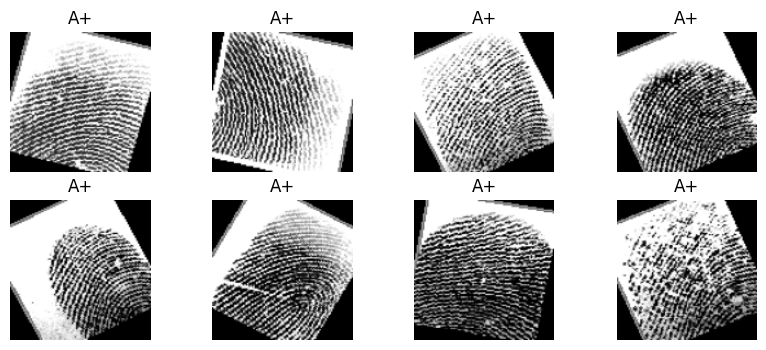

In [11]:
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(label_encoder.inverse_transform([y_encoded[i]])[0])
    plt.axis('off')
plt.show()


In [12]:
from skimage import exposure
from skimage.filters import gabor
from scipy.ndimage import gaussian_filter


In [ ]:
def enhance_fingerprint(img):
    """
    Advanced fingerprint enhancement pipeline
    """
    # Convert to uint8
    img = (img * 255).astype(np.uint8)

    # Step 1: Gaussian Denoising
    img_denoised = cv2.GaussianBlur(img, (5,5), 0)

    # Step 2: CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_denoised)

    # Step 3: Ridge Sharpening using Unsharp Mask
    blur = cv2.GaussianBlur(img_clahe, (9,9), 10)
    img_sharp = cv2.addWeighted(img_clahe, 1.5, blur, -0.5, 0)

    # Step 4: Normalize
    img_normalized = img_sharp / 255.0

    return img_normalized



: 

In [14]:
X_enhanced = np.array([enhance_fingerprint(img) for img in tqdm(X)])
X3_enhanced = np.array([enhance_fingerprint(img) for img in tqdm(X3)])

print("Enhanced Blood Group Dataset:", X_enhanced.shape)
print("Enhanced SOCOFing Dataset:", X3_enhanced.shape)


100%|██████████| 3000/3000 [00:04<00:00, 747.34it/s] 


Enhanced Blood Group Dataset: (13920, 128, 128)
Enhanced SOCOFing Dataset: (3000, 128, 128)


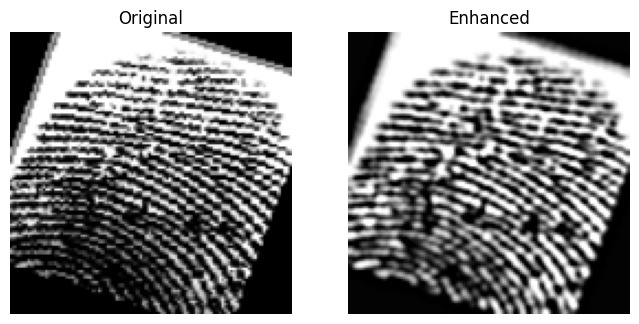

In [15]:
idx = np.random.randint(0, len(X))

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(X[idx], cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(X_enhanced[idx], cmap='gray')
plt.title("Enhanced")
plt.axis('off')

plt.show()



In [16]:
def gabor_enhancement(img):
    real, imag = gabor(img, frequency=0.6)
    return exposure.rescale_intensity(real, out_range=(0,1))


In [18]:
from skimage.filters import gabor
from skimage import exposure
X_gabor = np.array([gabor_enhancement(img) for img in tqdm(X_enhanced)], dtype=np.float32)
 

100%|██████████| 13920/13920 [00:30<00:00, 463.18it/s]


In [19]:
from collections import Counter

class_counts = Counter(y_encoded)
class_counts


Counter({1: 1999,
         6: 1842,
         3: 1751,
         5: 1731,
         7: 1702,
         2: 1698,
         4: 1642,
         0: 1555})

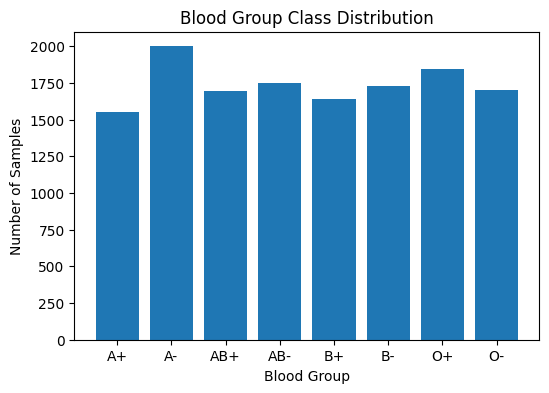

In [20]:
plt.figure(figsize=(6,4))
plt.bar(label_encoder.classes_, class_counts.values())
plt.title("Blood Group Class Distribution")
plt.xlabel("Blood Group")
plt.ylabel("Number of Samples")
plt.show()


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)


Train: (11136, 128, 128)
Test : (2784, 128, 128)


In [22]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 1.1189710610932475,
 1: 0.8705440900562852,
 2: 1.0250368188512518,
 3: 0.9935760171306209,
 4: 1.0593607305936072,
 5: 1.0050541516245488,
 6: 0.9443690637720489,
 7: 1.0227773695811904}

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()


c:\Users\kisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [24]:
# Expand dimensions for CNN
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn  = np.expand_dims(X_test, axis=-1)

print("CNN Train Shape:", X_train_cnn.shape)


CNN Train Shape: (11136, 128, 128, 1)


In [25]:
train_generator = train_datagen.flow(
    X_train_cnn, y_train,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test_cnn, y_test,
    batch_size=32
)


In [26]:
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


In [27]:
def extract_hog_features(images):
    hog_features = []
    for img in tqdm(images):
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )
        hog_features.append(features)
    return np.array(hog_features)


In [28]:
X_train_hog = extract_hog_features(X_train)
X_test_hog  = extract_hog_features(X_test)

print("HOG Train Shape:", X_train_hog.shape)


100%|██████████| 2784/2784 [00:07<00:00, 355.43it/s]

HOG Train Shape: (11136, 1764)


In [29]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_hog, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
y_pred_rf = rf_model.predict(X_test_hog)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))


Random Forest Accuracy: 0.9493534482758621
              precision    recall  f1-score   support

          A+       0.96      0.95      0.96       311
          A-       0.96      0.96      0.96       400
         AB+       0.93      0.94      0.94       340
         AB-       0.93      0.95      0.94       350
          B+       0.94      0.94      0.94       328
          B-       0.97      0.95      0.96       346
          O+       0.97      0.95      0.96       368
          O-       0.93      0.94      0.94       341

    accuracy                           0.95      2784
   macro avg       0.95      0.95      0.95      2784
weighted avg       0.95      0.95      0.95      2784



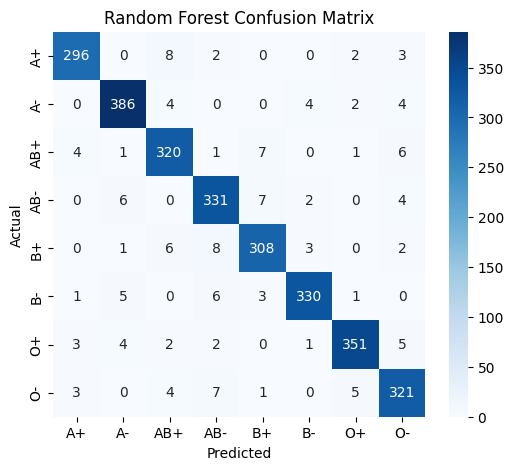

In [31]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


In [32]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)


In [33]:
from skimage.filters import gabor
from skimage.exposure import rescale_intensity


In [34]:
def extract_gabor_features(images, frequencies=[0.1, 0.3, 0.5]):
    features = []
    
    for img in tqdm(images):
        gabor_responses = []
        
        for freq in frequencies:
            real, imag = gabor(img, frequency=freq)
            gabor_responses.append(real.mean())
            gabor_responses.append(real.var())
            gabor_responses.append(imag.mean())
            gabor_responses.append(imag.var())
        
        features.append(gabor_responses)
    
    return np.array(features)


In [35]:
X_train_gabor = extract_gabor_features(X_train)
X_test_gabor  = extract_gabor_features(X_test)

print("Gabor Feature Shape:", X_train_gabor.shape)


100%|██████████| 2784/2784 [03:35<00:00, 12.92it/s]

Gabor Feature Shape: (11136, 12)


In [36]:
rf_gabor = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_gabor.fit(X_train_gabor, y_train)


,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_pred_gabor = rf_gabor.predict(X_test_gabor)

print("Gabor + RF Accuracy:", accuracy_score(y_test, y_pred_gabor))
print(classification_report(y_test, y_pred_gabor, target_names=label_encoder.classes_))


Gabor + RF Accuracy: 0.798132183908046
              precision    recall  f1-score   support

          A+       0.73      0.78      0.76       311
          A-       0.81      0.87      0.84       400
         AB+       0.75      0.81      0.78       340
         AB-       0.79      0.81      0.80       350
          B+       0.78      0.74      0.76       328
          B-       0.85      0.77      0.81       346
          O+       0.85      0.83      0.84       368
          O-       0.82      0.76      0.79       341

    accuracy                           0.80      2784
   macro avg       0.80      0.80      0.80      2784
weighted avg       0.80      0.80      0.80      2784



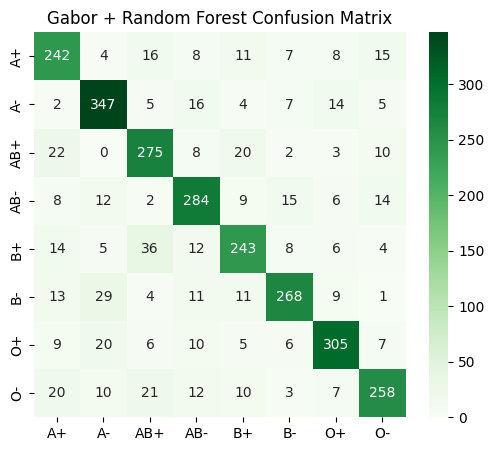

In [38]:
cm_gabor = confusion_matrix(y_test, y_pred_gabor)

plt.figure(figsize=(6,5))
sns.heatmap(cm_gabor, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Gabor + Random Forest Confusion Matrix")
plt.show()


In [39]:
gabor_rf_accuracy = accuracy_score(y_test, y_pred_gabor)


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [41]:
cnn_model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(len(label_encoder.classes_), activation='softmax')
])


c:\Users\kisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,518,408 (24.87 MB)

 Trainable params: 6,517,960 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


In [44]:
history = cnn_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 178s 478ms/step - accuracy: 0.1391 - loss: 2.4755 - val_accuracy: 0.2184 - val_loss: 3.4601 - learning_rate: 0.0010
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 153s 441ms/step - accuracy: 0.1455 - loss: 2.0808 - val_accuracy: 0.2091 - val_loss: 2.2261 - learning_rate: 0.0010
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 153s 440ms/step - accuracy: 0.2072 - loss: 1.9728 - val_accuracy: 0.1728 - val_loss: 2.2982 - learning_rate: 0.0010
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 153s 439ms/step - accuracy: 0.2455 - loss: 1.8570 - val_accuracy: 0.3552 - val_loss: 1.5919 - learning_rate: 0.0010
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 153s 438ms/step - accuracy: 0.2569 - loss: 1.8020 - val_accuracy: 0.2346 - val_loss: 1.8834 - learning_rate: 0.0010
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 153s 438ms/step - accuracy: 0.2658 - loss: 1.7801 - val_accuracy: 0.2011 - val_loss: 2.9164 - learning_rate: 0.0010
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 152s 438ms/step - accura

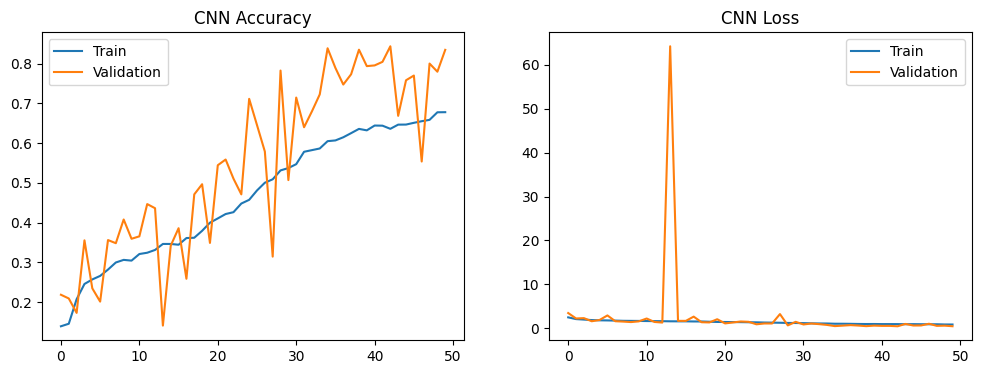

In [45]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("CNN Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("CNN Loss")
plt.legend()

plt.show()


In [46]:
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

print("CNN Accuracy:", accuracy_score(y_test, y_pred_cnn))
print(classification_report(y_test, y_pred_cnn, target_names=label_encoder.classes_))


87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step
CNN Accuracy: 0.8433908045977011
              precision    recall  f1-score   support

          A+       0.88      0.88      0.88       311
          A-       0.78      0.91      0.84       400
         AB+       0.86      0.81      0.84       340
         AB-       0.89      0.80      0.84       350
          B+       0.81      0.91      0.86       328
          B-       0.91      0.85      0.88       346
          O+       0.77      0.86      0.82       368
          O-       0.91      0.72      0.80       341

    accuracy                           0.84      2784
   macro avg       0.85      0.84      0.84      2784
weighted avg       0.85      0.84      0.84      2784



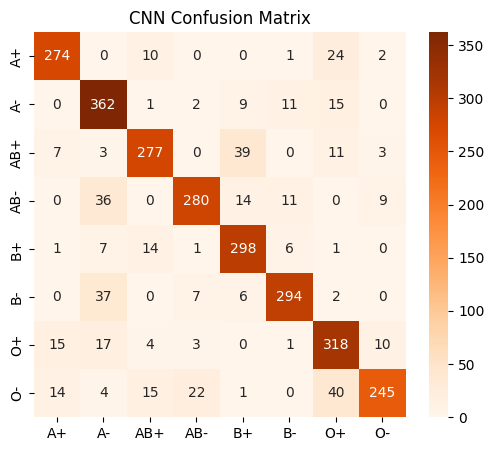

In [47]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("CNN Confusion Matrix")
plt.show()


In [48]:
# Convert grayscale to RGB
X_train_rgb = np.repeat(X_train_cnn, 3, axis=-1)
X_test_rgb  = np.repeat(X_test_cnn, 3, axis=-1)

print(X_train_rgb.shape)


(11136, 128, 128, 3)


In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [50]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [51]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(len(label_encoder.classes_), activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)


In [52]:
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [54]:
history_resnet = resnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_test_rgb, y_test),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 400s 819ms/step - accuracy: 0.5847 - loss: 1.0915 - val_accuracy: 0.6379 - val_loss: 0.9981 - learning_rate: 5.0000e-04
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 217s 616ms/step - accuracy: 0.5887 - loss: 1.0798 - val_accuracy: 0.6433 - val_loss: 0.9872 - learning_rate: 5.0000e-04
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 215s 617ms/step - accuracy: 0.5978 - loss: 1.0603 - val_accuracy: 0.6509 - val_loss: 0.9638 - learning_rate: 5.0000e-04
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 218s 626ms/step - accuracy: 0.6042 - loss: 1.0463 - val_accuracy: 0.6444 - val_loss: 0.9672 - learning_rate: 5.0000e-04
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 221s 631ms/step - accuracy: 0.6114 - loss: 1.0308 - val_accuracy: 0.6433 - val_loss: 0.9509 - learning_rate: 5.0000e-04
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 217s 621ms/step - accuracy: 0.6166 - loss: 0.9992 - val_accuracy: 0.6566 - val_loss: 0.9345 - learning_rate: 2.5000e-04
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 

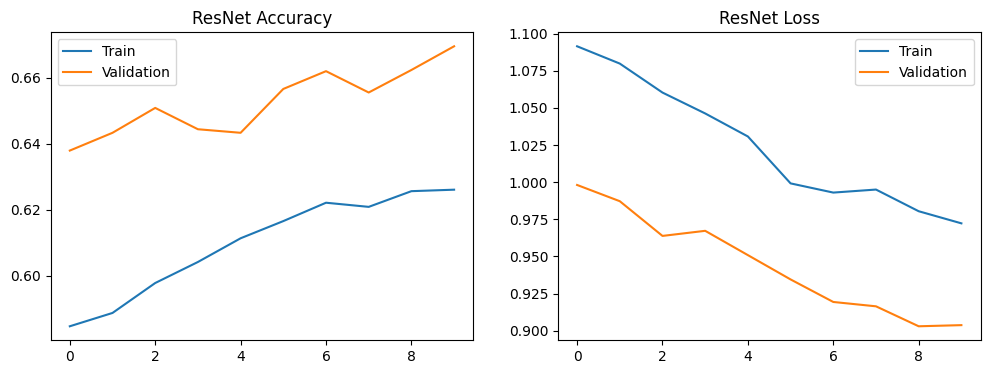

In [55]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_resnet.history['accuracy'], label='Train')
plt.plot(history_resnet.history['val_accuracy'], label='Validation')
plt.title("ResNet Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_resnet.history['loss'], label='Train')
plt.plot(history_resnet.history['val_loss'], label='Validation')
plt.title("ResNet Loss")
plt.legend()

plt.show()


In [56]:
y_pred_resnet = resnet_model.predict(X_test_rgb)
y_pred_resnet = np.argmax(y_pred_resnet, axis=1)

print("ResNet Accuracy:", accuracy_score(y_test, y_pred_resnet))
print(classification_report(y_test, y_pred_resnet, target_names=label_encoder.classes_))


87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step
ResNet Accuracy: 0.6379310344827587
              precision    recall  f1-score   support

          A+       0.63      0.70      0.66       311
          A-       0.62      0.58      0.60       400
         AB+       0.65      0.56      0.60       340
         AB-       0.63      0.60      0.62       350
          B+       0.75      0.65      0.69       328
          B-       0.73      0.69      0.71       346
          O+       0.60      0.61      0.61       368
          O-       0.55      0.73      0.63       341

    accuracy                           0.64      2784
   macro avg       0.65      0.64      0.64      2784
weighted avg       0.64      0.64      0.64      2784



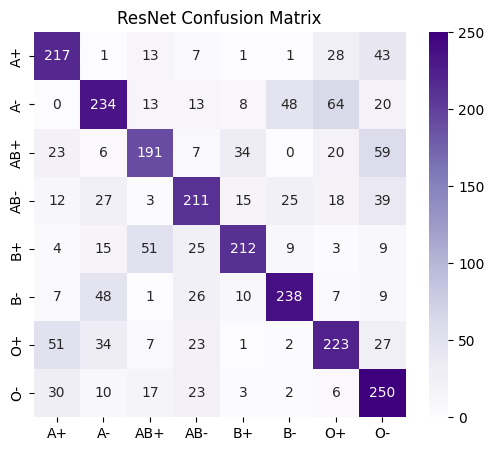

In [57]:
cm_resnet = confusion_matrix(y_test, y_pred_resnet)

plt.figure(figsize=(6,5))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("ResNet Confusion Matrix")
plt.show()


In [58]:
resnet_accuracy = accuracy_score(y_test, y_pred_resnet)


In [64]:
# Ensure the Sequential CNN is built/called before accessing .inputs (prevents AttributeError)
if not getattr(cnn_model, "inputs", None):
    # Call the model once on a dummy batch to properly build it and create input tensors
    cnn_model(tf.zeros((1, 128, 128, 1), dtype=tf.float32))

cnn_feature_model = tf.keras.Model(
    inputs=cnn_model.inputs,
    outputs=cnn_model.layers[-2].output
)

X_train_cnn_feat = cnn_feature_model.predict(X_train_cnn)
X_test_cnn_feat  = cnn_feature_model.predict(X_test_cnn)


348/348 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step


In [65]:
resnet_feature_model = tf.keras.Model(
    inputs=resnet_model.input,
    outputs=resnet_model.layers[-2].output
)

X_train_resnet_feat = resnet_feature_model.predict(X_train_rgb)
X_test_resnet_feat  = resnet_feature_model.predict(X_test_rgb)

348/348 ━━━━━━━━━━━━━━━━━━━━ 15460s 594ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 471ms/step


In [66]:
X_train_deep = np.concatenate(
    (X_train_cnn_feat, X_train_resnet_feat), axis=1
)

X_test_deep = np.concatenate(
    (X_test_cnn_feat, X_test_resnet_feat), axis=1
)

print("Final Feature Shape:", X_train_deep.shape)


Final Feature Shape: (11136, 512)


In [67]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [68]:
svm_model = SVC(
    kernel='rbf',
    probability=True,
    random_state=42
)
svm_model.fit(X_train_deep, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [69]:
knn_model = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance'
)
knn_model.fit(X_train_deep, y_train)


,n_neighbors,7
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [70]:
cnn_probs    = cnn_model.predict(X_test_cnn)
resnet_probs = resnet_model.predict(X_test_rgb)
svm_probs    = svm_model.predict_proba(X_test_deep)
knn_probs    = knn_model.predict_proba(X_test_deep)


87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 89s 496ms/step


In [71]:
stacked_features = np.concatenate(
    (cnn_probs, resnet_probs, svm_probs, knn_probs),
    axis=1
)


In [72]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(max_iter=2000)
meta_model.fit(stacked_features, y_test)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [73]:
y_pred_ensemble = meta_model.predict(stacked_features)


In [74]:
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)

print("🔥 ENSEMBLE MODEL ACCURACY:", ensemble_accuracy)
print(classification_report(
    y_test, y_pred_ensemble,
    target_names=label_encoder.classes_
))


🔥 ENSEMBLE MODEL ACCURACY: 0.9533045977011494
              precision    recall  f1-score   support

          A+       0.98      0.95      0.96       311
          A-       0.97      0.97      0.97       400
         AB+       0.91      0.96      0.94       340
         AB-       0.95      0.95      0.95       350
          B+       0.95      0.93      0.94       328
          B-       0.97      0.95      0.96       346
          O+       0.95      0.97      0.96       368
          O-       0.95      0.94      0.94       341

    accuracy                           0.95      2784
   macro avg       0.95      0.95      0.95      2784
weighted avg       0.95      0.95      0.95      2784



C:\Users\kisha\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


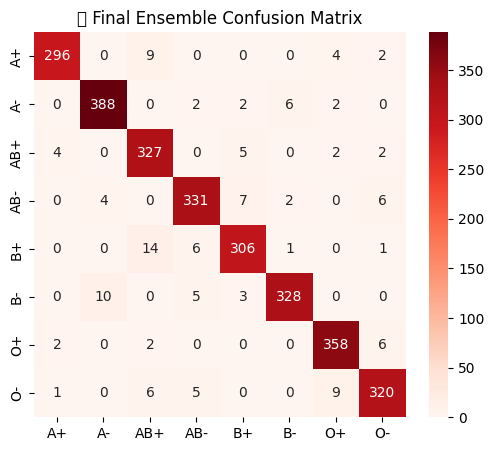

In [75]:
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_ensemble, annot=True, fmt='d', cmap='Reds',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("🔥 Final Ensemble Confusion Matrix")
plt.show()


In [78]:
results = pd.DataFrame({
    "Model": [
        "Random Forest (HOG)",
        "Gabor + RF",
        "Custom CNN",
        "ResNet50",
        "🔥 Ensemble Model"
    ],
    "Accuracy": [
        rf_accuracy,
        gabor_rf_accuracy,
        accuracy_score(y_test, y_pred_cnn),
        resnet_accuracy,
        ensemble_accuracy
    ]
})

results


,Model,Accuracy
0,Random Forest (HOG),0.949353
1,Gabor + RF,0.798132
2,Custom CNN,0.843391
3,ResNet50,0.637931
4,🔥 Ensemble Model,0.953305


In [79]:
# Save deep learning models
cnn_model.save("cnn_model.h5")
resnet_model.save("resnet_model.h5")

# Save ML models
import joblib
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(knn_model, "knn_model.pkl")
joblib.dump(meta_model, "meta_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']